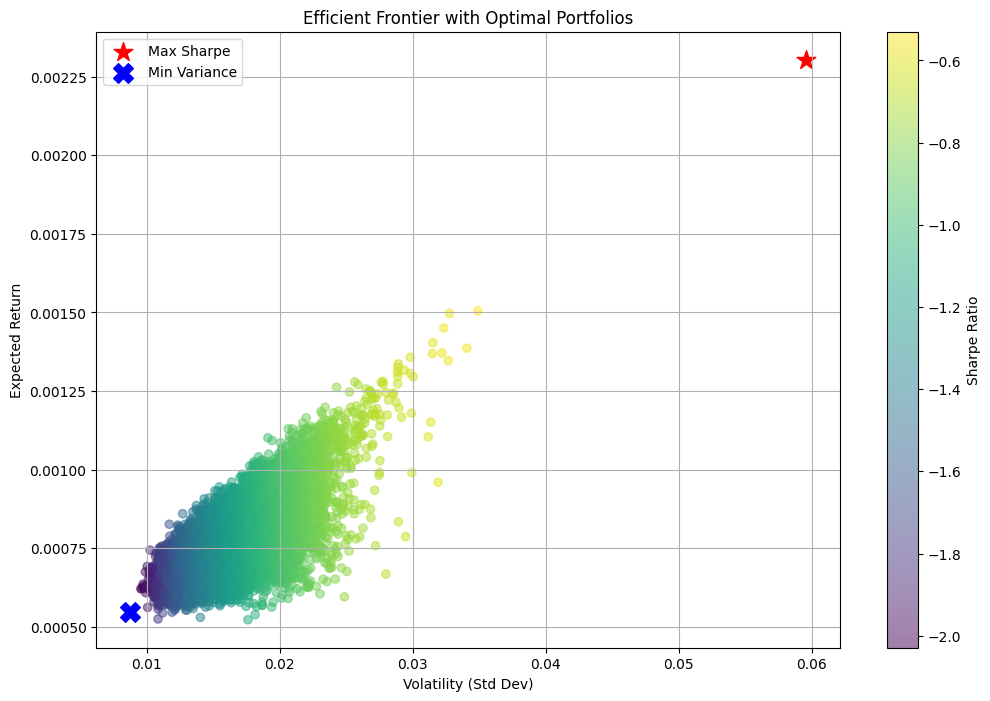

✅ Saved: max_sharpe_weights.csv and min_var_weights.csv


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
import os

# Load returns
returns = pd.read_csv("../data/processed/portfolio_returns.csv", index_col=0, parse_dates=True)
tickers = returns.columns.tolist()

# Mean and covariance
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_assets = len(tickers)
init_guess = [1. / num_assets] * num_assets

def portfolio_performance(weights, mean_returns, cov_matrix):
    ret = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return std, ret

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.02):
    std, ret = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(ret - risk_free_rate) / std

def min_variance(weights, mean_returns, cov_matrix):
    std, _ = portfolio_performance(weights, mean_returns, cov_matrix)
    return std

def get_constraints():
    return [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]

def get_bounds(n):
    return tuple((0, 1) for _ in range(n))

# Max Sharpe
opt_sharpe = sco.minimize(
    neg_sharpe_ratio,
    init_guess,
    args=(mean_returns, cov_matrix),
    method='SLSQP',
    bounds=get_bounds(num_assets),
    constraints=get_constraints()
)

# Min Variance
opt_minvar = sco.minimize(
    min_variance,
    init_guess,
    args=(mean_returns, cov_matrix),
    method='SLSQP',
    bounds=get_bounds(num_assets),
    constraints=get_constraints()
)

def simulate_portfolios(n_sim=10000):
    results = np.zeros((3, n_sim))
    for i in range(n_sim):
        weights = np.random.dirichlet(np.ones(num_assets), size=1).flatten()
        std, ret = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe = (ret - 0.02) / std
        results[0,i] = std
        results[1,i] = ret
        results[2,i] = sharpe
    return results

results = simulate_portfolios()

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(results[0], results[1], c=results[2], cmap='viridis', alpha=0.5)
plt.colorbar(label="Sharpe Ratio")

# Optimal points
sharpe_std, sharpe_ret = portfolio_performance(opt_sharpe.x, mean_returns, cov_matrix)
minvar_std, minvar_ret = portfolio_performance(opt_minvar.x, mean_returns, cov_matrix)

plt.scatter(sharpe_std, sharpe_ret, marker='*', color='r', s=200, label='Max Sharpe')
plt.scatter(minvar_std, minvar_ret, marker='X', color='b', s=200, label='Min Variance')

plt.title("Efficient Frontier with Optimal Portfolios")
plt.xlabel("Volatility (Std Dev)")
plt.ylabel("Expected Return")
plt.legend()
plt.grid(True)
plt.show()

# Format results as named Series
sharpe_weights = pd.Series(opt_sharpe.x, index=tickers, name="Weight")
minvar_weights = pd.Series(opt_minvar.x, index=tickers, name="Weight")

# Save separately
os.makedirs("../data/processed/", exist_ok=True)
sharpe_weights.to_csv("../data/processed/max_sharpe_weights.csv")
minvar_weights.to_csv("../data/processed/min_var_weights.csv")

print("✅ Saved: max_sharpe_weights.csv and min_var_weights.csv")


